CCS なら厳しめのパラメタで daligner をやるだけでいけるんじゃないかということでやってみる。

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = 'plotly_white'
import logging
import logzero
logzero.loglevel(logging.INFO)

In [66]:
from BITS.util.io import load_pickle, save_pickle
from BITS.util.proc import run_command
from BITS.seq.io import save_fasta
from BITS.plot.plotly import make_line, make_hist, make_scatter, make_layout, show_plot
import numpy as np
import pandas as pd
from logzero import logger
import numpy as np
import pandas as pd
import igraph as ig
from collections import Counter
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
from copy import copy
import pandas as pd
from BITS.clustering.seq import ClusteringSeq
from BITS.seq.align import EdlibRunner
from BITS.seq.consed import ConsedRunner
from BITS.util.io import save_pickle, load_pickle
from BITS.util.io import load_pickle, save_pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from BITS.plot.plotly import make_hist, make_scatter, make_layout, show_plot
from BITS.clustering.seq import ClusteringSeq
import consed
from BITS.seq.align import EdlibRunner
from collections import Counter, defaultdict
from logzero import logger
from dataclasses import dataclass
from typing import List, Tuple
import random
from copy import copy
from collections import Counter
from dataclasses import dataclass
from logzero import logger
import numpy as np
from vca.types import TRUnit
from BITS.clustering.seq import ClusteringSeq
from BITS.seq.align import EdlibRunner
from BITS.util.io import load_pickle, save_pickle
from BITS.util.proc import NoDaemonPool
from BITS.seq.utils import revcomp

In [3]:
dir_fname = 'work_ovlp_filter/'
import os
os.chdir(dir_fname)

In [6]:
!(ls -l)

合計 4
-rw-r--r-- 1 yoshihiko_s users 194  9月 20 23:21 2019 DMEL.db
lrwxrwxrwx 1 yoshihiko_s users  50  9月 20 23:17 2019 centromere_reads_incl_low_cover_rate.fasta -> ../work/centromere_reads_incl_low_cover_rate.fasta


## Check the k-mer distribution

In [55]:
def read_to_forward_units(read):
    """Return all units contained in <read> so that starnd of every unit is same as the forward master unit."""
    return [read.seq[unit.start:unit.end] if unit.id == 0 else revcomp(read.seq[unit.start:unit.end])
            for unit in read.units]

In [56]:
sync_reads = load_pickle("../work/centromere_reads_incl_low_cover_rate_all_sync.pkl")

In [57]:
len(sync_reads)

1905

In [58]:
sync_units = []
for read in sync_reads:
    sync_units += read_to_forward_units(read)

In [59]:
len(sync_units)

46539

In [60]:
k = 24
all_kmers = Counter()
for read in sync_reads:
    for i in range(read.length - k + 1):
        all_kmers[read.seq[i:i + k]] += 1
        all_kmers[revcomp(read.seq[i:i + k])] += 1

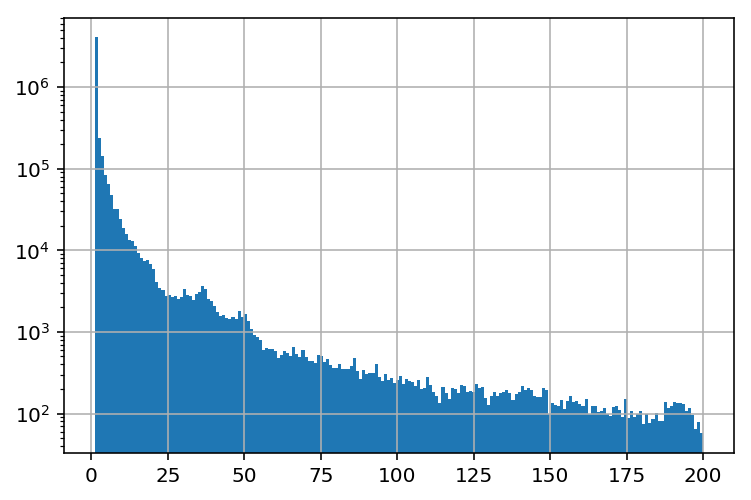

In [69]:
# k-mer frequency (x-axis) の頻度 (y-axis)
pd.Series(list(all_kmers.values())).hist(bins=200, range=(1, 200))
plt.yscale('log')
plt.show()

In [70]:
k = 40
all_kmers = Counter()
for read in sync_reads:
    for i in range(read.length - k + 1):
        all_kmers[read.seq[i:i + k]] += 1
        all_kmers[revcomp(read.seq[i:i + k])] += 1

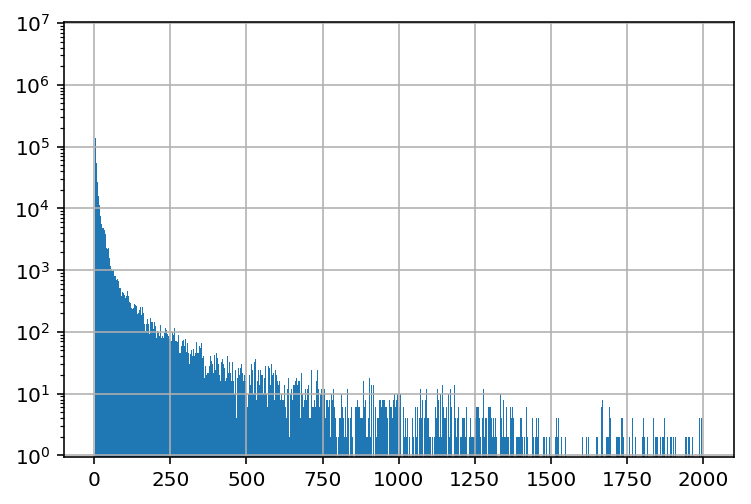

In [153]:
# k-mer frequency (x-axis) の頻度 (y-axis)
pd.Series(list(all_kmers.values())).hist(bins=2000, range=(1, 2000))
plt.yscale('log')
plt.show()

## Run daligner

In [72]:
!(rm *.las)

In [73]:
!(HPC.daligner -T16 -k20 -w5 -l3000 -h50 -e.95 -s500 -t300 DMEL | bash -v)

# Daligner jobs (1)
daligner -k20 -w5 -h50 -t300 -e0.95 -l3000 -s500 -T16 DMEL DMEL && mv DMEL.DMEL.las DMEL.las
# Check initial .las files jobs (1) (optional but recommended)
LAcheck -vS DMEL DMEL
  DMEL: 1,332,122 all OK


In [49]:
!(LAshow -oc DMEL.db DMEL.las | head -10)


DMEL: 243,368 records

     1     107 c   [ 7,848..13,814> x <12,959.. 6,984]  (12,959 x 13,814 bps,13 trace pts)

         7848 
    A  =======+---------->           dif/(len1+len2) = 37/(5966+5975) =  0.62%
    B         <----------+=======
                           6984



In [50]:
!(LAdump -ocdl DMEL.db DMEL.las | head -10)

+ P 22972
% P 521
P 1 107 c .
L 13814 12959
C 7848 13814 0 5975
D 37
P 1 809 n .
L 13814 11653
C 0 9406 2240 11653
D 15


revcomp の時の b_read の start/end がややこしいので気をつける (LAshow と LAdump で数字が逆)

## Load overlaps from las

In [8]:
def las_to_ovlps(db_prefix):
    ovlps = []
    for line in run_command(f"LAdump -ocdl {db_prefix}.db {db_prefix}.las").split('\n'):
        if line.startswith('P'):
            _, a_read, b_read, strand, _ = line.strip().split(' ')
            a_read, b_read = map(int, (a_read, b_read))
        elif line.startswith('L'):
            _, a_len, b_len = line.strip().split(' ')
            a_len, b_len = map(int, (a_len, b_len))
        elif line.startswith('C'):
            _, a_start, a_end, b_start, b_end = line.strip().split(' ')
            a_start, a_end, b_start, b_end = map(int, (a_start, a_end, b_start, b_end))
        elif line.startswith('D'):
            _, n_diff = line.strip().split(' ')
            n_diff = int(n_diff)
            p_diff = round(n_diff / ((a_end - a_start + b_end - b_start) / 2) * 100, 2)   # in percentage
            ovlps.append((a_read, b_read, strand, a_start, a_end, a_len, b_start, b_end, b_len, n_diff, p_diff))
    return ovlps

## Construct a string graph from the filtered overlaps

In [9]:
def construct_string_graph(overlaps):
    nodes, edges = set(), set()
    for overlap in overlaps:
        f_id, g_id, strand, a_start, a_end, a_len, b_start, b_end, b_len, n_diff, p_diff = overlap
        
        if strand == 'c':
            # a_read[a_start:a_end] ~~ strand(b_read[b_start:b_end]) となるようにする
            # b の座標は常に b_read を forward に見た時のもの。配列の切り出しが先。revcomp は後。
            b_start, b_end = b_len - b_end, b_len - b_start
            
        if a_start > 0:
            if strand == 'n':
                if b_end == b_len:
                    """
                         f.B               f.E
                      f  ----------------->
                      g     --------->
                          g.B        g.E
                    """
                    overlap_type = "contains"
                else:
                    """
                         f.B         f.E
                      f  ----------->
                      g         ------------->
                                g.B           g.E
                    """
                    overlap_type = "suffix-prefix"
            else:
                if b_start == 0:
                    """
                         f.B               f.E
                      f  ----------------->
                      g     <---------
                          g.E        g.B
                    """
                    overlap_type = "contains"
                else:
                    """
                         f.B         f.E
                      f  ----------->
                      g         <-------------
                                g.E           g.B
                    """
                    overlap_type = "suffix-suffix"
        else:
            if a_end == a_len:
                overlap_type = "contained"
            else:
                if strand == 'n':
                    """
                                f.B         f.E
                      f          ----------->
                      g    ----------->
                         g.B          g.E
                    """
                    if b_start == 0:
                        overlap_type = "contains"
                    else:
                        overlap_type = "prefix-suffix"
                else:
                    """
                                f.B         f.E
                      f          ----------->
                      g    <-----------
                         g.E           g.B
                    """
                    if b_end == b_len:
                        overlap_type = "contains"
                    else:
                        overlap_type = "prefix-prefix"

        if overlap_type in ["contains", "contained"]:
            continue
        elif overlap_type == "suffix-prefix":
            nodes.update(["%s:B" % g_id,
                          "%s:B" % f_id,
                          "%s:E" % f_id,
                          "%s:E" % g_id])
            edges.update([("%s:B" % g_id, "%s:B" % f_id, a_start, p_diff),
                          ("%s:E" % f_id, "%s:E" % g_id, b_len - b_end, p_diff)])
        elif overlap_type == "suffix-suffix":
            nodes.update(["%s:E" % g_id,
                          "%s:B" % f_id,
                          "%s:E" % f_id,
                          "%s:B" % g_id])
            edges.update([("%s:E" % g_id, "%s:B" % f_id, a_start, p_diff),
                          ("%s:E" % f_id, "%s:B" % g_id, b_start, p_diff)])
        elif overlap_type == "prefix-suffix":
            nodes.update(["%s:B" % f_id,
                          "%s:B" % g_id,
                          "%s:E" % g_id,
                          "%s:E" % f_id])
            edges.update([("%s:B" % f_id, "%s:B" % g_id, b_start, p_diff),
                          ("%s:E" % g_id, "%s:E" % f_id, a_len - a_end, p_diff)])
        else:   # prefix-prefix
            nodes.update(["%s:B" % f_id,
                          "%s:E" % g_id,
                          "%s:B" % g_id,
                          "%s:E" % f_id])
            edges.update([("%s:B" % f_id, "%s:E" % g_id, b_len - b_end, p_diff),
                          ("%s:B" % g_id, "%s:E" % f_id, a_len - a_end, p_diff)])

    return ig.Graph.DictList(edges=(dict(source=s, target=t, length=l, diff=p) for s, t, l, p in edges),
                             vertices=None,
                             directed=True)

def transitive_reduction(sg):
    v_mark = ["vacant" for v in sg.vs]
    e_reduce = {e.tuple: False for e in sg.es}
    FUZZ = 10   # in bp; this length is in general shorter than unit length, thus we accept no unit shifts

    for v in sg.vs:
        if v.outdegree() == 0:
            continue

        oes = sorted(sg.es.select(_source=v.index), key=lambda x: x["length"])
        longest = oes[-1]["length"] + FUZZ
        for oe in oes:
            v_mark[oe.target] = "inplay"

        for oe in oes:
            if v_mark[oe.target] == "inplay":
                ooes = sorted(sg.es.select(_source=oe.target), key=lambda x: x["length"])
                for ooe in ooes:
                    if oe["length"] + ooe["length"] <= longest and v_mark[ooe.target] == "inplay":
                        v_mark[ooe.target] = "eliminated"

        for oe in oes:
            ooes = sorted(sg.es.select(_source=oe.target), key=lambda x: x["length"])
            if len(ooes) > 1:
                shortest = ooes[0].target
                if v_mark[shortest] == "inplay":
                    v_mark[shortest] == "eliminated"
            for ooe in ooes:
                if ooe["length"] < FUZZ and v_mark[ooe.target] == "inplay":
                    v_mark[ooe.target] = "eliminated"

        for oe in oes:
            if v_mark[oe.target] == "eliminated":
                e_reduce[oe.tuple] = True   # TODO: confirm revcomp edges will be also removed in the same way
            v_mark[oe.target] = "vacant"

    # Re-construct a graph
    return ig.Graph.DictList(edges=(dict(source=e["source"],
                                         target=e["target"],
                                         length=e["length"],
                                         diff=e["diff"])
                                    for e in sg.es
                                    if not e_reduce[e.tuple]),
                             vertices=None,
                             directed=True)

In [10]:
def draw_graph(sg):
    E = [e.tuple for e in sg.es]
    N = sg.vcount()
    pos = sg.layout('kk')

    edge_trace = go.Scatter(x=[i for l in [(pos[s][0], pos[t][0], None) for s, t in E] for i in l],
                            y=[i for l in [(pos[s][1], pos[t][1], None) for s, t in E] for i in l],
                            line=dict(width=0.5, color='black'),
                            mode='lines')

    shapes = [make_line(pos[s][0] + (pos[t][0] - pos[s][0]) * 0.7,
                        pos[s][1] + (pos[t][1] - pos[s][1]) * 0.7,
                        pos[t][0],
                        pos[t][1],
                        "black",
                        4,
                        "below")
              for s, t in E]

    node_trace = go.Scatter(x=[pos[node][0] for node in range(N)],
                            y=[pos[node][1] for node in range(N)],
                            text=[sg.vs[node]["name"] for node in range(N)],
                            mode='markers',
                            marker=dict(
                                showscale=False,
                                colorscale='YlGnBu',
                                reversescale=True,
                                size=10,
                                line=dict(width=2)))

    layout = go.Layout(width=1000, height=1000,
                       xaxis=dict(showgrid=False,
                                  zeroline=True,
                                  zerolinecolor="yellow",
                                  showticklabels=True),
                       yaxis=dict(showgrid=False,
                                  zeroline=True,
                                  zerolinecolor="yellow",
                                  showticklabels=True),
                       shapes=shapes,
                       hovermode='closest',
                       margin=go.layout.Margin(l=0, r=0, b=0, t=0),
                       showlegend=False)
    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    py.iplot(fig)
    return pos

In [139]:
ovlps = las_to_ovlps("DMEL")

In [140]:
len(ovlps)

221522

In [141]:
# Remove duplicated overlaps and filter by %diff and overlap length
#ovlps = list(filter(lambda ovlp: ovlp[0] < ovlp[1] and ovlp[-1] < 3. and ovlp[4] - ovlp[3] >= 3000, ovlps))

# No dup ovlps removal
ovlps = list(filter(lambda ovlp: ovlp[-1] < 3. and ovlp[4] - ovlp[3] >= 3000, ovlps))

In [142]:
len(ovlps)

10845

In [143]:
ovlps[:10]

[(1, 107, 'c', 7848, 13814, 13814, 0, 5975, 12959, 37, 0.62),
 (1, 398, 'n', 0, 6601, 13814, 6365, 12988, 12988, 175, 2.65),
 (1, 809, 'n', 0, 9406, 13814, 2240, 11653, 11653, 15, 0.16),
 (1, 855, 'c', 0, 6541, 13814, 6386, 12944, 12944, 171, 2.61),
 (1, 1368, 'c', 10485, 13814, 13814, 0, 3329, 13424, 11, 0.33),
 (1, 1663, 'c', 10100, 13814, 13814, 0, 3719, 12144, 7, 0.19),
 (3, 5, 'c', 8324, 11396, 11396, 0, 3063, 12117, 61, 1.99),
 (3, 384, 'c', 8224, 11396, 11396, 0, 3154, 13950, 59, 1.87),
 (3, 783, 'c', 8260, 11396, 11396, 0, 3125, 12858, 62, 1.98),
 (4, 259, 'c', 0, 3393, 13059, 9345, 12735, 12735, 73, 2.15)]

In [114]:
# 各リードの overlap の数
n_ovlps = Counter()
for ovlp in ovlps:
    n_ovlps[ovlp[0]] += 1
    n_ovlps[ovlp[1]] += 1

In [115]:
n_ovlps_for_each_read = [n_ovlps[read_id] for read_id in range(1, 1906)]

In [116]:
show_plot([make_hist(n_ovlps_for_each_read, bin_size=1)])

In [91]:
sg = construct_string_graph(ovlps)

In [92]:
cc = [(g, g.vcount()) for g in sg.clusters(mode="weak").subgraphs() if g.vcount() >= 10]

In [93]:
cc

[(<igraph.Graph at 0x2b9a9d26e408>, 26),
 (<igraph.Graph at 0x2b9a9e244c78>, 1970),
 (<igraph.Graph at 0x2b9a9e244e58>, 14),
 (<igraph.Graph at 0x2b9a9e26e048>, 14),
 (<igraph.Graph at 0x2b9a9e26e318>, 14),
 (<igraph.Graph at 0x2b9a9e26e4f8>, 12),
 (<igraph.Graph at 0x2b9a9e26e5e8>, 11),
 (<igraph.Graph at 0x2b9a9e26e7c8>, 14),
 (<igraph.Graph at 0x2b9a9e26ea98>, 17),
 (<igraph.Graph at 0x2b9a9e26eb88>, 14),
 (<igraph.Graph at 0x2b9a9e26ec78>, 10),
 (<igraph.Graph at 0x2b9a9e26ed68>, 57),
 (<igraph.Graph at 0x2b9a9e273138>, 10),
 (<igraph.Graph at 0x2b9a9e2737c8>, 12),
 (<igraph.Graph at 0x2b9a9e273b88>, 15),
 (<igraph.Graph at 0x2b9a9e287318>, 15),
 (<igraph.Graph at 0x2b9a9e2877c8>, 14),
 (<igraph.Graph at 0x2b9a9df4c048>, 57),
 (<igraph.Graph at 0x2b9a9df4c138>, 22),
 (<igraph.Graph at 0x2b9a9df4c228>, 17),
 (<igraph.Graph at 0x2b9a9df4c408>, 22),
 (<igraph.Graph at 0x2b9a9df4c6d8>, 21),
 (<igraph.Graph at 0x2b9a9df4c7c8>, 29),
 (<igraph.Graph at 0x2b9a9df4c8b8>, 29),
 (<igraph.Grap

In [94]:
draw_graph(cc[1][0])

<Layout with 1970 vertices and 2 dimensions>

In [144]:
cur_id_to_ori_id = {i + 1: sync_reads[i].id for i in range(len(sync_reads))}

In [145]:
original_dbid_ovlps = [(cur_id_to_ori_id[ovlp[0]], cur_id_to_ori_id[ovlp[1]], *ovlp[2:]) for ovlp in ovlps]

In [154]:
# Extract overlaps of a read
read_id = 236
read_ovlps = list(filter(lambda x: x[0] == read_id or x[1] == read_id, original_dbid_ovlps))
for o in read_ovlps:
    print(o)
tuple(set([xx for x in read_ovlps for xx in x[:2]]))

(236, 369, 'c', 8324, 11396, 11396, 0, 3063, 12117, 61, 1.99)
(236, 87619, 'c', 8224, 11396, 11396, 0, 3154, 13950, 59, 1.87)
(236, 191931, 'c', 8260, 11396, 11396, 0, 3125, 12858, 62, 1.98)
(369, 236, 'c', 9054, 12117, 12117, 0, 3072, 11396, 61, 1.99)
(87619, 236, 'c', 10796, 13950, 13950, 0, 3172, 11396, 59, 1.87)
(191931, 236, 'c', 9733, 12858, 12858, 0, 3136, 11396, 62, 1.98)


(369, 87619, 236, 191931)